# Feature extraction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import utils.feature_extraction_helpers as feh
import matplotlib.pyplot as plt
import geopandas as gpd

# Set paths
data_dir = '../data/preprocessed/sentinel'
aoi_path = '../utils/AOI_bboxes/aoi_shifa.geojson'

In [3]:
# COLLECT BACKSCATTER VALUES
# # Use sample_rate < 1.0 for faster processing during development
# all_backscatter = feh.collect_all_backscatter_values_optimized(data_dir, aoi_path=aoi_path, sample_rate=1)

# all_backscatter.to_file('../data/preprocessed/all_backscatter.gpkg', driver='GPKG')

# LOAD BACKSCATTER VALUES
all_backscatter = gpd.read_file('../data/preprocessed/all_backscatter.gpkg')

In [5]:
# Load labelled data points (data/processed/combined_damage_control_points.gpkg)
labelled_data = gpd.read_file('../data/processed/labels/combined_damage_control_points.gpkg')

In [6]:
# Extract backscatter values for all labelled points
backscatter_points = feh.extract_backscatter_for_points(
    points_gdf=labelled_data,  # combined damage + control points
    backscatter_gdf=all_backscatter,  # backscatter data
    buffer_distance=10  # Buffer distance in meters
)

Extracting backscatter values for 5932 points with 10m buffer...
Converting points from EPSG:9707 to EPSG:4326
Converting to UTM for accurate buffering...


Extracting backscatter values:   0%|          | 0/5932 [00:00<?, ?it/s]

Extracted 613250 backscatter values for 5932 points

Values by polarization:
polarization
VV    306625
VH    306625
Name: count, dtype: int64

Values by orbit:
orbit
UNK    613250
Name: count, dtype: int64

Values by date:


TypeError: '<' not supported between instances of 'str' and 'Timestamp'

In [ ]:
# Save the raw data for reference
backscatter_points.to_csv("../data/analysis/backscatter_at_points.csv", index=False)

In [17]:
# Data exploration for all_backscatter dataset
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import folium
from folium.plugins import HeatMap
import os
import random
from datetime import datetime

# 1. Basic dataframe exploration
print("Dataset overview:")
print(f"Total records: {len(all_backscatter)}")
print(f"Unique pixels: {all_backscatter['pixel_id'].nunique()}")
print(f"Unique dates: {all_backscatter['date'].nunique()}")
print(f"Date range: {all_backscatter['date'].min()} to {all_backscatter['date'].max()}")

# Show data types and missing values
print("\nDataset information:")
all_backscatter.info()

# Summary statistics for backscatter values
print("\nBackscatter value statistics:")
backscatter_stats = all_backscatter.groupby(['polarization', 'period'])['backscatter'].describe()
display(backscatter_stats)

Dataset overview:
Total records: 4537582
Unique pixels: 131507
Unique dates: 14
Date range: 20230427 to 20240528

Dataset information:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4537582 entries, 0 to 4537581
Data columns (total 11 columns):
 #   Column        Dtype   
---  ------        -----   
 0   row           int64   
 1   col           int64   
 2   lon           float64 
 3   lat           float64 
 4   backscatter   float32 
 5   date          object  
 6   polarization  object  
 7   orbit         object  
 8   period        object  
 9   pixel_id      object  
 10  geometry      geometry
dtypes: float32(1), float64(2), geometry(1), int64(2), object(5)
memory usage: 363.5+ MB

Backscatter value statistics:


count       mean       std   min        25%  \
polarization period                                                       
VH           post        972336.0 -13.172178  4.321579 -70.0 -15.530434   
             reference  1296455.0 -13.127200  4.610758 -70.0 -15.598712   
VV           post        972336.0  -7.439239  3.644640 -70.0  -9.701392   
             reference  1296455.0  -7.710838  3.918175 -70.0 -10.163866   

                              50%        75%        max  
polarization period                                      
VH           post      -12.840139 -10.404153   8.394497  
             reference -12.833855 -10.251289  13.658458  
VV           post       -7.319242  -5.053552  20.026560  
             reference  -7.623405  -5.181228  17.451103

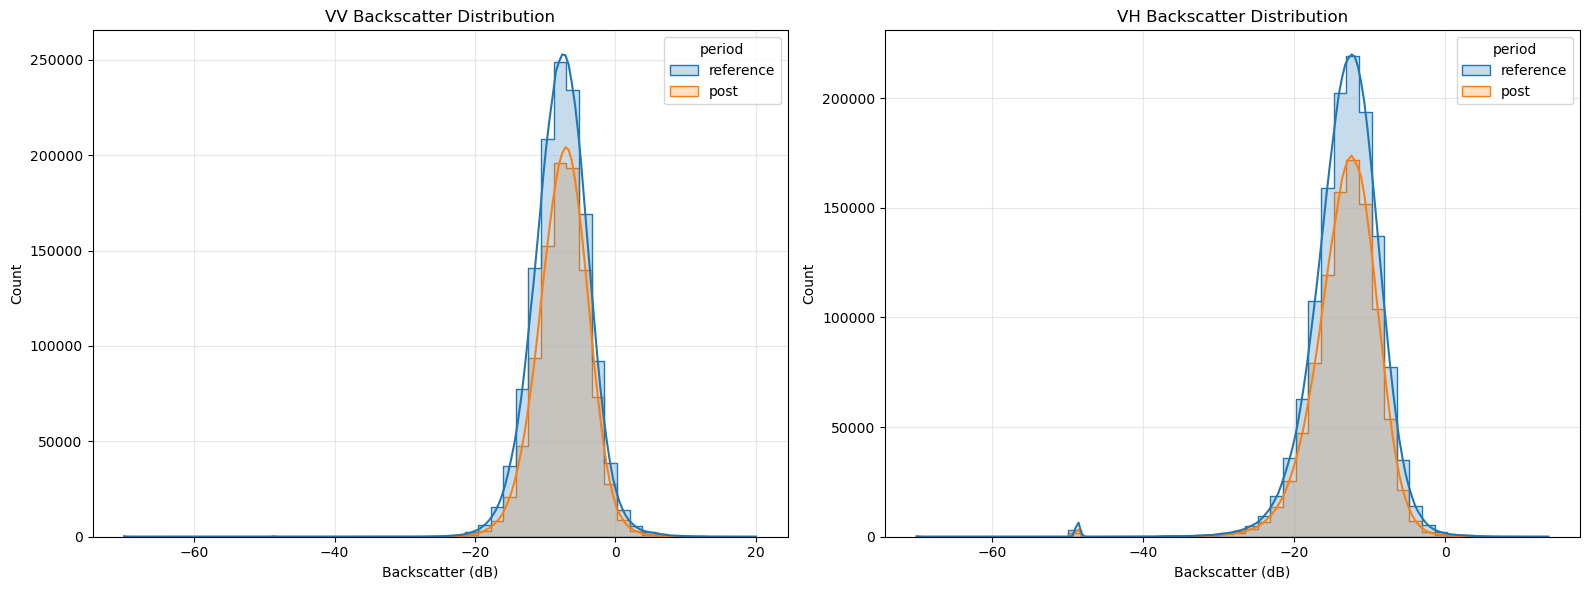

In [19]:
# 2. Distribution of backscatter values by polarization and period
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=all_backscatter[all_backscatter['polarization'] == 'VV'], 
             x='backscatter', hue='period', bins=50, kde=True, element='step')
plt.title('VV Backscatter Distribution')
plt.xlabel('Backscatter (dB)')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sns.histplot(data=all_backscatter[all_backscatter['polarization'] == 'VH'], 
             x='backscatter', hue='period', bins=50, kde=True, element='step')
plt.title('VH Backscatter Distribution')
plt.xlabel('Backscatter (dB)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# 3. Spatial visualization - sample points on a map
# Create a folium map centered on the data
center_lat = all_backscatter['lat'].mean()
center_lon = all_backscatter['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=14, tiles='CartoDB positron')

# Sample a small number of points to visualize (too many will slow down the browser)
sample_size = min(2000, len(all_backscatter))
sample_points = all_backscatter.sample(sample_size)

# Create a colormap for backscatter values
vmin = sample_points['backscatter'].min()
vmax = sample_points['backscatter'].max()

# Add points to the map
for idx, row in sample_points.iterrows():
    # Normalize backscatter value for color
    norm_value = (row['backscatter'] - vmin) / (vmax - vmin)
    
    # Create a color (red for low, blue for high backscatter)
    color = f'#{int(255 * (1-norm_value)):02x}{0:02x}{int(255 * norm_value):02x}'
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"ID: {row['pixel_id']}<br>Date: {row['date']}<br>Backscatter: {row['backscatter']:.2f} dB<br>Pol: {row['polarization']}"
    ).add_to(m)

# Save the map to an HTML file
map_file = 'sample_points_map.html'
m.save(map_file)
print(f"Interactive map saved to {map_file}")

Interactive map saved to sample_points_map.html


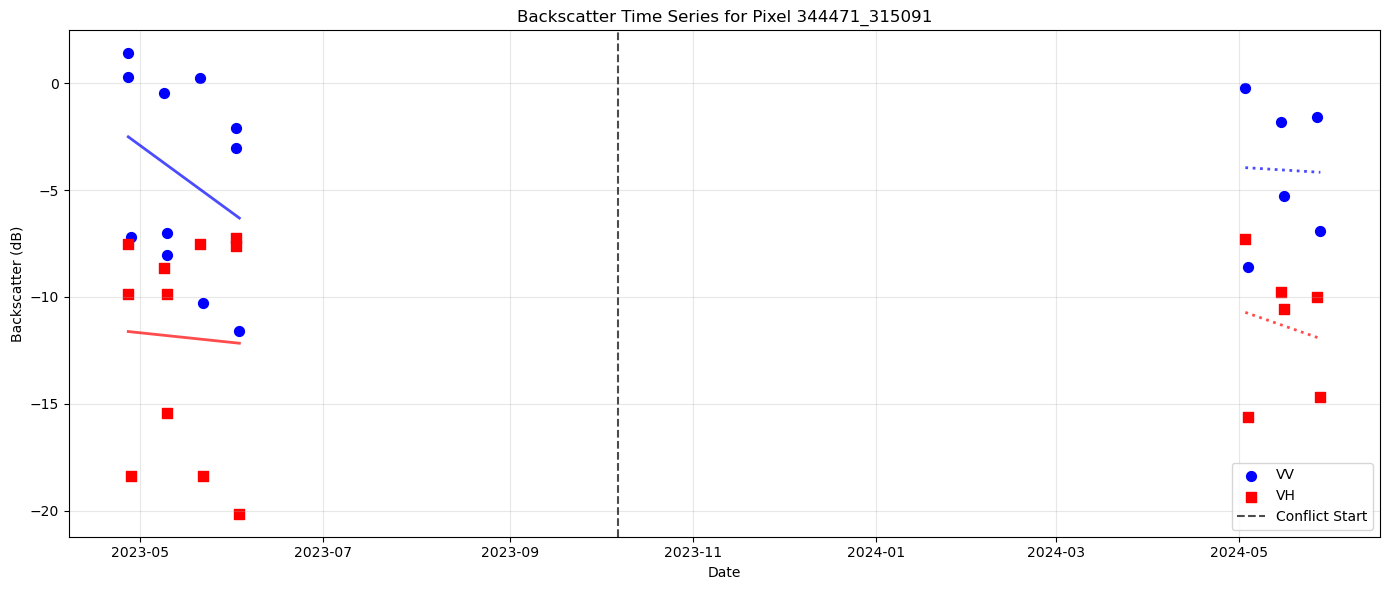


Statistics for Pixel 344471_315091:
VV reference: Mean = -4.35 dB, Std = 4.63 dB, Count = 11
VV post: Mean = -4.06 dB, Std = 3.35 dB, Count = 6
VH reference: Mean = -11.89 dB, Std = 5.11 dB, Count = 11
VH post: Mean = -11.34 dB, Std = 3.19 dB, Count = 6

Changes:
VV Change: 0.29 dB (6.6%)
VH Change: 0.55 dB (4.6%)
VV/VH Ratio Change: -0.26 dB


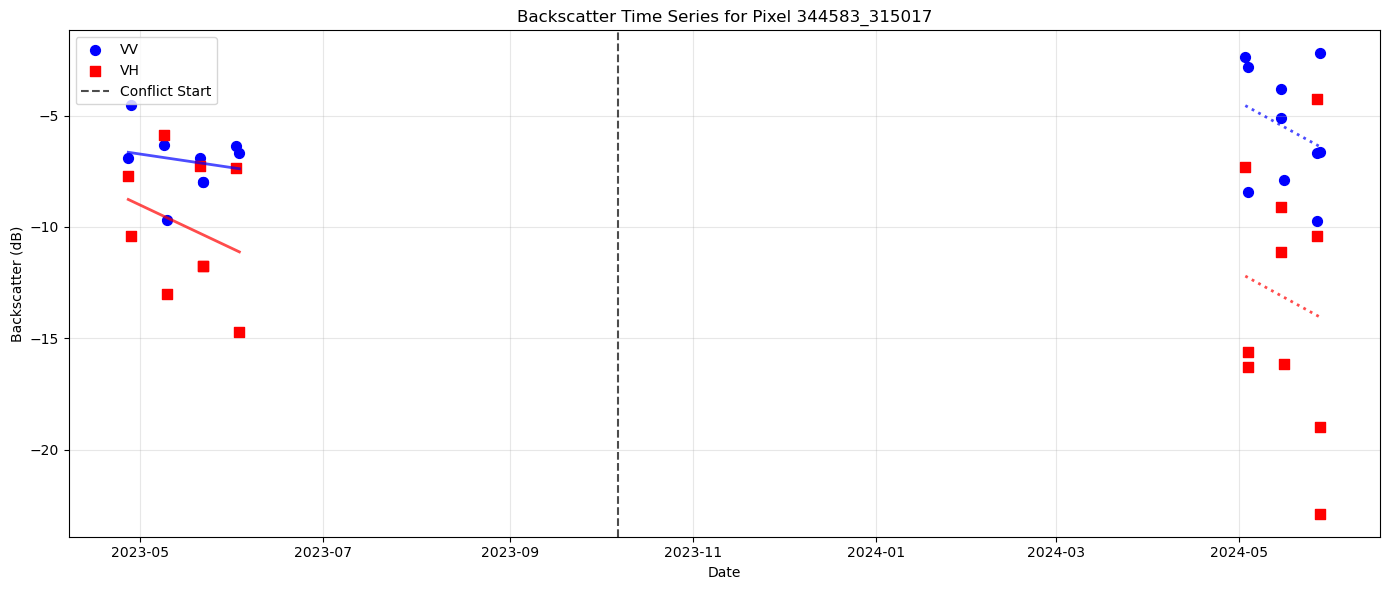


Statistics for Pixel 344583_315017:
VV reference: Mean = -7.03 dB, Std = 1.42 dB, Count = 9
VV post: Mean = -5.56 dB, Std = 2.71 dB, Count = 10
VH reference: Mean = -9.99 dB, Std = 3.06 dB, Count = 9
VH post: Mean = -13.22 dB, Std = 5.71 dB, Count = 10

Changes:
VV Change: 1.46 dB (20.8%)
VH Change: -3.23 dB (-32.4%)
VV/VH Ratio Change: 4.70 dB


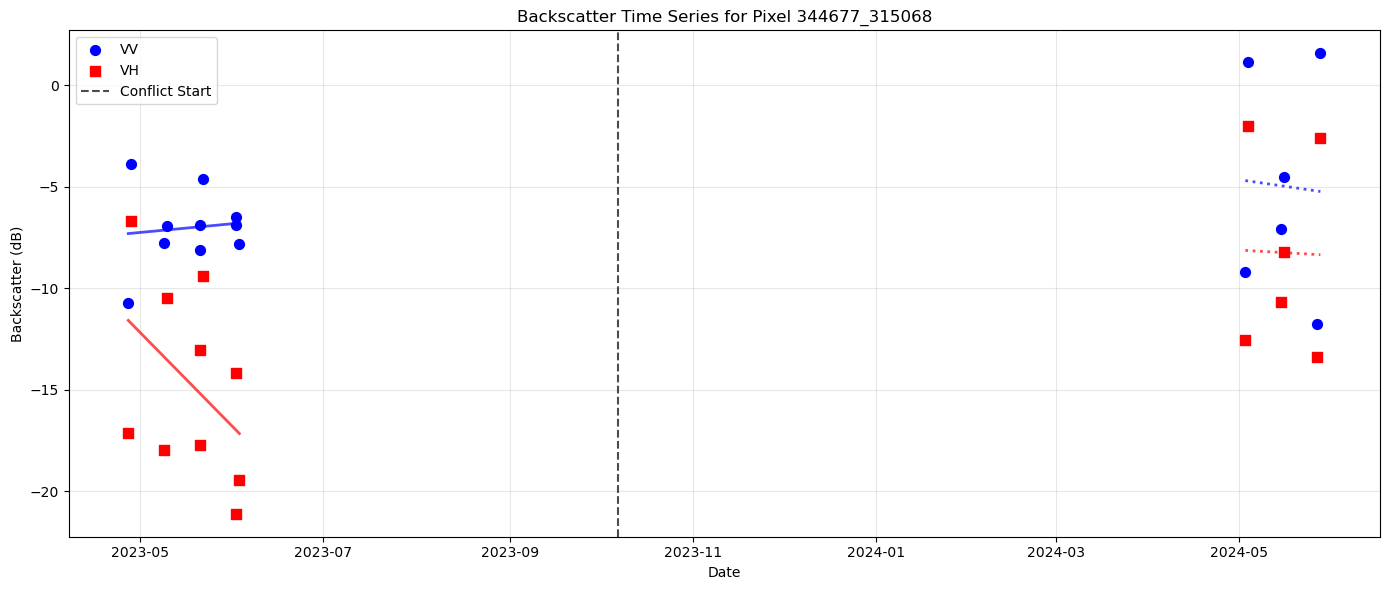


Statistics for Pixel 344677_315068:
VV reference: Mean = -7.02 dB, Std = 1.88 dB, Count = 10
VV post: Mean = -4.97 dB, Std = 5.44 dB, Count = 6
VH reference: Mean = -14.71 dB, Std = 4.74 dB, Count = 10
VH post: Mean = -8.24 dB, Std = 4.93 dB, Count = 6

Changes:
VV Change: 2.05 dB (29.2%)
VH Change: 6.47 dB (44.0%)
VV/VH Ratio Change: -4.42 dB


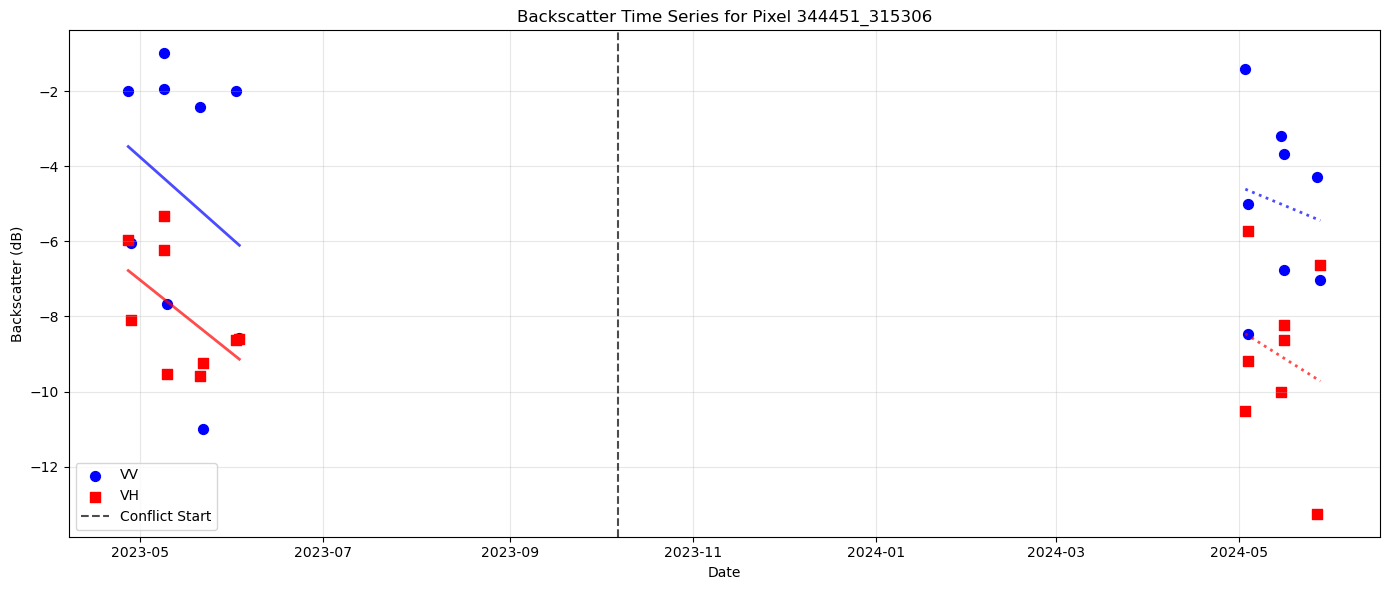


Statistics for Pixel 344451_315306:
VV reference: Mean = -4.74 dB, Std = 3.65 dB, Count = 9
VV post: Mean = -4.98 dB, Std = 2.32 dB, Count = 8
VH reference: Mean = -7.91 dB, Std = 1.64 dB, Count = 9
VH post: Mean = -9.02 dB, Std = 2.34 dB, Count = 8

Changes:
VV Change: -0.24 dB (-5.1%)
VH Change: -1.11 dB (-14.0%)
VV/VH Ratio Change: 0.87 dB


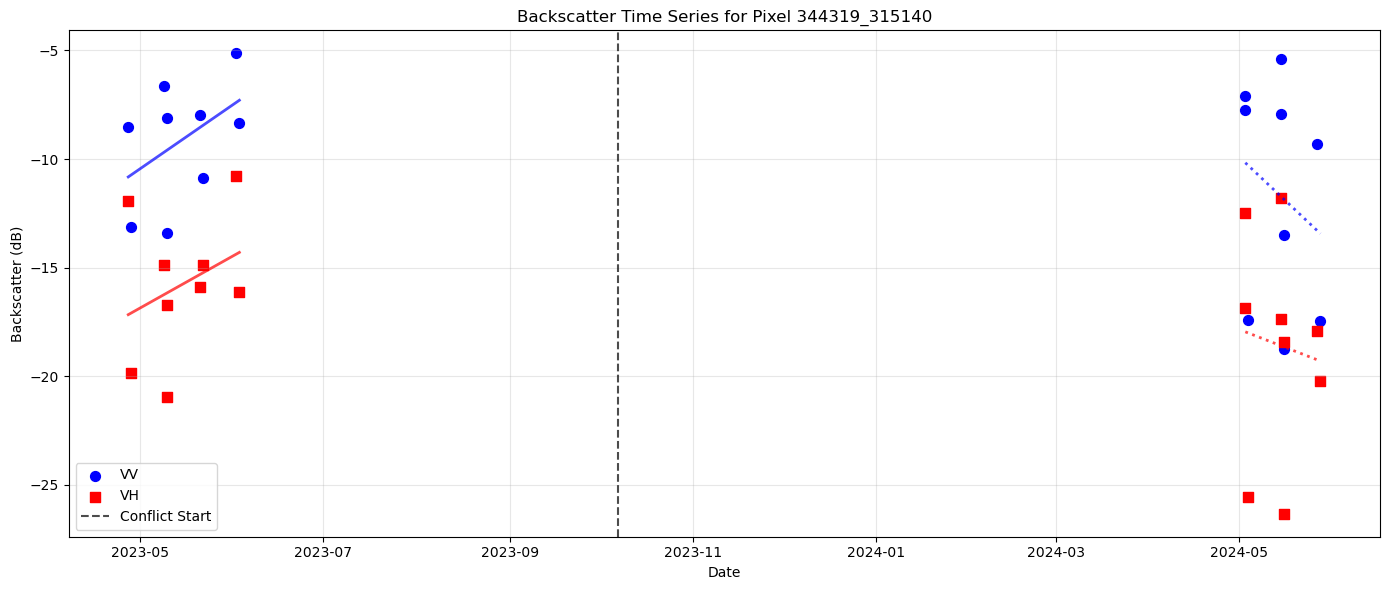


Statistics for Pixel 344319_315140:
VV reference: Mean = -9.12 dB, Std = 2.81 dB, Count = 9
VV post: Mean = -11.62 dB, Std = 5.18 dB, Count = 9
VH reference: Mean = -15.78 dB, Std = 3.28 dB, Count = 9
VH post: Mean = -18.55 dB, Std = 4.99 dB, Count = 9

Changes:
VV Change: -2.50 dB (-27.5%)
VH Change: -2.77 dB (-17.6%)
VV/VH Ratio Change: 0.27 dB


In [24]:
# 5. Time series visualization for random pixels
# Select a few random pixels to visualize
random_pixels = random.sample(list(all_backscatter['pixel_id'].unique()), 5)

for pixel_id in random_pixels:
    pixel_data = all_backscatter[all_backscatter['pixel_id'] == pixel_id].copy()
    
    # Only proceed if we have both periods and polarizations
    if (pixel_data['period'] == 'reference').any() and (pixel_data['period'] == 'post').any() and \
       (pixel_data['polarization'] == 'VV').any() and (pixel_data['polarization'] == 'VH').any():
        
        # Convert dates to datetime
        pixel_data['datetime'] = pd.to_datetime(pixel_data['date'], format='%Y%m%d')
        
        # Plot the time series
        plt.figure(figsize=(14, 6))
        
        # VV polarization
        vv_data = pixel_data[pixel_data['polarization'] == 'VV']
        plt.scatter(vv_data['datetime'], vv_data['backscatter'], 
                   label='VV', color='blue', marker='o', s=50)
        
        # VH polarization
        vh_data = pixel_data[pixel_data['polarization'] == 'VH']
        plt.scatter(vh_data['datetime'], vh_data['backscatter'], 
                   label='VH', color='red', marker='s', s=50)
        
        # Add conflict date
        conflict_date = pd.to_datetime('20231007', format='%Y%m%d')
        plt.axvline(x=conflict_date, color='black', linestyle='--', alpha=0.7, label='Conflict Start')
        
        # Add trend lines
        for pol, color in [('VV', 'blue'), ('VH', 'red')]:
            pol_data = pixel_data[pixel_data['polarization'] == pol]
            
            for period, linestyle in [('reference', '-'), ('post', ':')]:
                period_data = pol_data[pol_data['period'] == period]
                if len(period_data) > 1:  # Need at least 2 points for a line
                    try:
                        # Convert to numeric for regression
                        x = (period_data['datetime'] - period_data['datetime'].min()).dt.days
                        y = period_data['backscatter']
                        
                        # Linear regression
                        z = np.polyfit(x, y, 1)
                        p = np.poly1d(z)
                        
                        # Plot trend line
                        x_days = np.array([x.min(), x.max()])
                        x_dates = period_data['datetime'].min() + pd.to_timedelta(x_days, unit='D')
                        plt.plot(x_dates, p(x_days), color=color, linestyle=linestyle, 
                                alpha=0.7, linewidth=2)
                    except:
                        pass  # Skip if regression fails
        
        plt.title(f'Backscatter Time Series for Pixel {pixel_id}')
        plt.xlabel('Date')
        plt.ylabel('Backscatter (dB)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print statistics for this pixel
        print(f"\nStatistics for Pixel {pixel_id}:")
        for pol in ['VV', 'VH']:
            for period in ['reference', 'post']:
                data = pixel_data[(pixel_data['polarization'] == pol) & (pixel_data['period'] == period)]
                if len(data) > 0:
                    print(f"{pol} {period}: Mean = {data['backscatter'].mean():.2f} dB, " +
                          f"Std = {data['backscatter'].std():.2f} dB, Count = {len(data)}")
        
        # Calculate changes
        vv_ref = pixel_data[(pixel_data['polarization'] == 'VV') & (pixel_data['period'] == 'reference')]['backscatter'].mean()
        vv_post = pixel_data[(pixel_data['polarization'] == 'VV') & (pixel_data['period'] == 'post')]['backscatter'].mean()
        vh_ref = pixel_data[(pixel_data['polarization'] == 'VH') & (pixel_data['period'] == 'reference')]['backscatter'].mean()
        vh_post = pixel_data[(pixel_data['polarization'] == 'VH') & (pixel_data['period'] == 'post')]['backscatter'].mean()
        
        vv_change = vv_post - vv_ref
        vh_change = vh_post - vh_ref
        ratio_ref = vv_ref - vh_ref
        ratio_post = vv_post - vh_post
        ratio_change = ratio_post - ratio_ref
        
        print("\nChanges:")
        print(f"VV Change: {vv_change:.2f} dB ({vv_change/abs(vv_ref)*100:.1f}%)")
        print(f"VH Change: {vh_change:.2f} dB ({vh_change/abs(vh_ref)*100:.1f}%)")
        print(f"VV/VH Ratio Change: {ratio_change:.2f} dB")
        print("="*50)

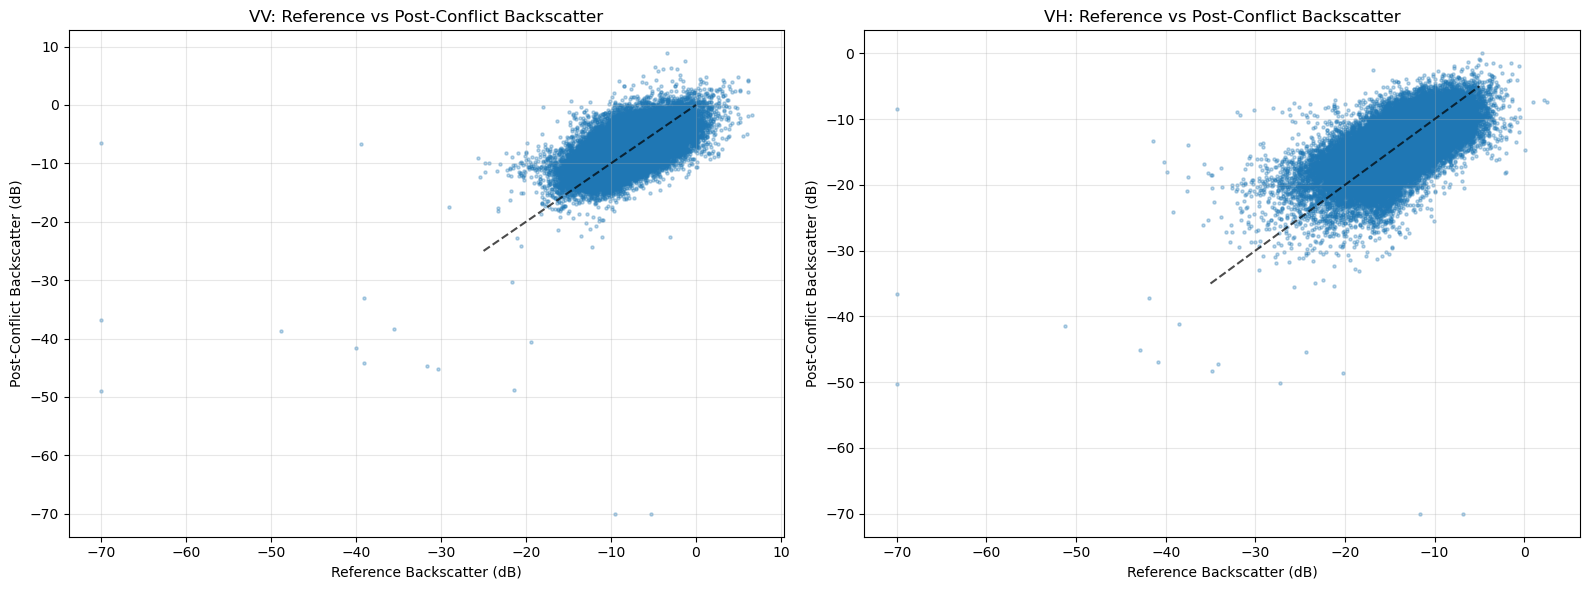

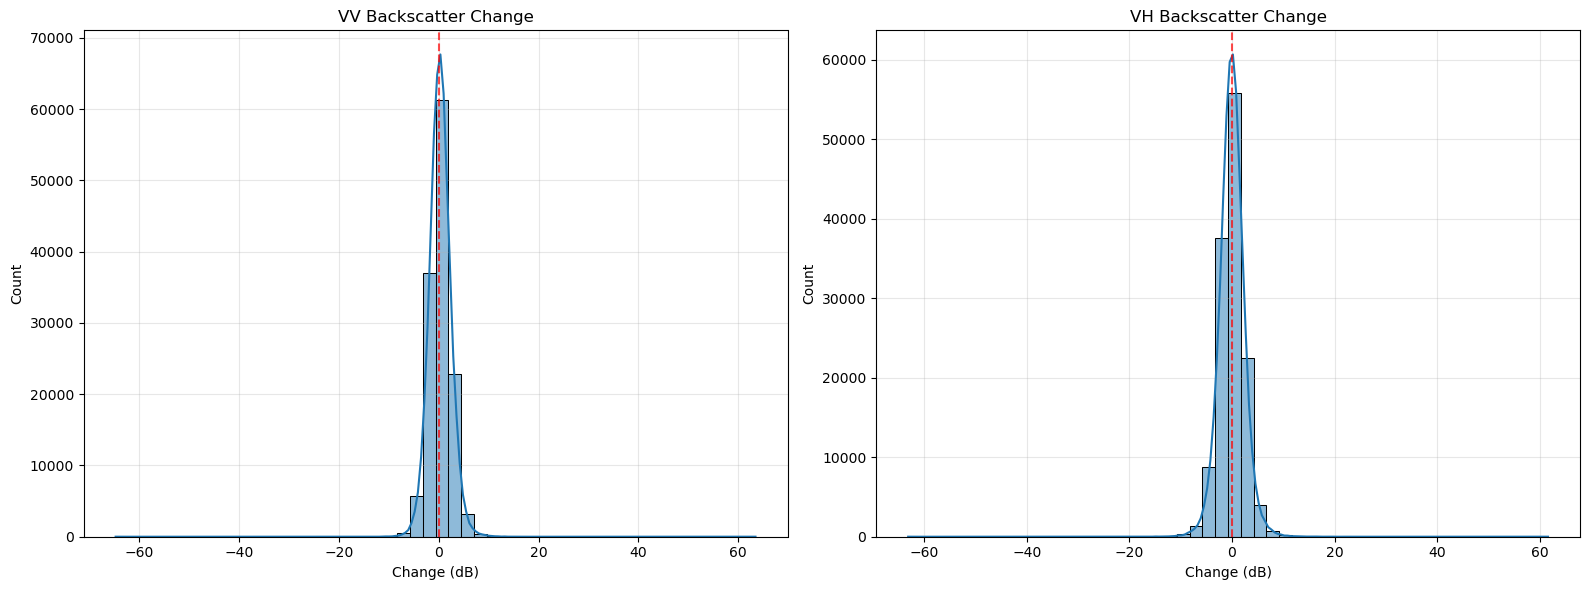

change                                                     \
                 count      mean       std        min       25%       50%   
polarization                                                                
VH            131195.0 -0.043985  2.462936 -63.114365 -1.501181 -0.046172   
VV            131195.0  0.272879  2.198352 -64.731033 -1.096795  0.234796   

                                  percent_change                         \
                   75%        max          count       mean         std   
polarization                                                              
VH            1.404893  61.561779       131195.0  -2.851109   42.600201   
VV            1.592540  63.470417       131195.0 -12.718760  450.691162   

                                                                          
                       min        25%       50%        75%           max  
polarization                                                              
VH           -12649.856445 -12.533423 -0.360337  10.282695     99.973907  
VV           -86520.242188 -16.222586  3.048790  19.099672  10257.491211

In [25]:
# 6. Correlation between reference and post-conflict backscatter
ref_post_comparison = []

# Group by pixel and polarization to compare reference vs post
for (pixel, pol), group in all_backscatter.groupby(['pixel_id', 'polarization']):
    ref_data = group[group['period'] == 'reference']
    post_data = group[group['period'] == 'post']
    
    if len(ref_data) > 0 and len(post_data) > 0:
        ref_post_comparison.append({
            'pixel_id': pixel,
            'polarization': pol,
            'ref_value': ref_data['backscatter'].mean(),
            'post_value': post_data['backscatter'].mean(),
            'change': post_data['backscatter'].mean() - ref_data['backscatter'].mean(),
            'percent_change': ((post_data['backscatter'].mean() - ref_data['backscatter'].mean()) / 
                              abs(ref_data['backscatter'].mean())) * 100
        })

ref_post_df = pd.DataFrame(ref_post_comparison)

# Plot reference vs post values
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(ref_post_df[ref_post_df['polarization'] == 'VV']['ref_value'], 
           ref_post_df[ref_post_df['polarization'] == 'VV']['post_value'], 
           alpha=0.3, s=5)
plt.plot([-25, 0], [-25, 0], 'k--', alpha=0.7)  # 1:1 line
plt.title('VV: Reference vs Post-Conflict Backscatter')
plt.xlabel('Reference Backscatter (dB)')
plt.ylabel('Post-Conflict Backscatter (dB)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(ref_post_df[ref_post_df['polarization'] == 'VH']['ref_value'], 
           ref_post_df[ref_post_df['polarization'] == 'VH']['post_value'], 
           alpha=0.3, s=5)
plt.plot([-35, -5], [-35, -5], 'k--', alpha=0.7)  # 1:1 line
plt.title('VH: Reference vs Post-Conflict Backscatter')
plt.xlabel('Reference Backscatter (dB)')
plt.ylabel('Post-Conflict Backscatter (dB)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of changes
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=ref_post_df[ref_post_df['polarization'] == 'VV'], 
             x='change', bins=50, kde=True)
plt.title('VV Backscatter Change')
plt.xlabel('Change (dB)')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.histplot(data=ref_post_df[ref_post_df['polarization'] == 'VH'], 
             x='change', bins=50, kde=True)
plt.title('VH Backscatter Change')
plt.xlabel('Change (dB)')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics of changes
change_summary = ref_post_df.groupby('polarization')[['change', 'percent_change']].describe()
display(change_summary)

In [ ]:
# 7. Largest changes
print("\nTop 10 pixels with largest VV increase:")
display(ref_post_df[ref_post_df['polarization'] == 'VV'].nlargest(10, 'change'))

print("\nTop 10 pixels with largest VV decrease:")
display(ref_post_df[ref_post_df['polarization'] == 'VV'].nsmallest(10, 'change'))

print("\nTop 10 pixels with largest VH increase:")
display(ref_post_df[ref_post_df['polarization'] == 'VH'].nlargest(10, 'change'))

print("\nTop 10 pixels with largest VH decrease:")
display(ref_post_df[ref_post_df['polarization'] == 'VH'].nsmallest(10, 'change'))